## Declaration of Authorship {.unnumbered .unlisted}

We, \[DeskB\], confirm that the work presented in this assessment is our own. Where information has been derived from other sources, we confirm that this has been indicated in the work. Where a Large Language Model such as ChatGPT has been used we confirm that we have made its contribution to the final submission clear.

Date: 11th December 2023

Student Numbers: 20017359 23032922 23081403 23103585 23130397

## Brief Group Reflection

| What Went Well | What Was Challenging |
|----------------|----------------------|
| A              | B                    |
| C              | D                    |

## Priorities for Feedback

Are there any areas on which you would appreciate more detailed feedback if we're able to offer it?



```{=html}
<style type="text/css">
.duedate {
  border: dotted 2px red; 
  background-color: rgb(255, 235, 235);
  height: 50px;
  line-height: 50px;
  margin-left: 40px;
  margin-right: 40px
  margin-top: 10px;
  margin-bottom: 10px;
  color: rgb(150,100,100);
  text-align: center;
}
</style>
```

{{< pagebreak >}}





# Response to Questions


**Import all packages**

In [156]:
import os
import spacy
import pandas as pd
import numpy as np
import geopandas as gpd
import re
import math
import string
import unicodedata
import gensim
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
from joblib import dump
from joblib import load
import contextily as ctx

from scipy.spatial.distance import cdist

from shapely.geometry import Point

from sklearn.preprocessing import OneHotEncoder  # We don't use this but I point out where you *could*
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC


from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk import ngrams, FreqDist

from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.matutils import Sparse2Corpus
from gensim.matutils import corpus2dense
from gensim.models import tfidfmodel
from gensim.models import Word2Vec
from gensim.models import TfidfModel
from gensim.models import KeyedVectors
from gensim.models.ldamodel import LdaModel

from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS


# Import everthing from textual/__init__.py
# Including bunch of tools and functions we could use for NLP 
from textual import *

In [2]:
lemmatizer = WordNetLemmatizer()
tokenizer = ToktokTokenizer()

In [3]:
# Some Configuration allowing us to output Markdown (like this cell) instead of plain text
from IPython.display import display_markdown

def as_markdown(head='', body='Some body text'):
    if head != '':
        display_markdown(f"##### {head}\n\n>{body}\n", raw=True)
    else:
        display_markdown(f">{body}\n", raw=True)

as_markdown('Result!', "Here's my output...")

##### Result!

>Here's my output...


**Loading the Data**

In [4]:
# Download and read the csv file remotely from url
host = 'http://data.insideairbnb.com'
path = 'united-kingdom/england/london/2023-09-06/data'
file = 'listings.csv.gz'
url  = f'{host}/{path}/{file}'

# Save csv file
if os.path.exists(file):
  Airbnb_Listing = pd.read_csv(file, compression='gzip', low_memory=False)
else: 
  Airbnb_Listing = pd.read_csv(url, compression='gzip', low_memory=False)
  Airbnb_Listing.to_csv(file)

# Download and read the gpkg file remotel from url
host = 'https://data.london.gov.uk'
path = 'download/london_boroughs/9502cdec-5df0-46e3-8aa1-2b5c5233a31f'
file = 'London_Boroughs.gpkg'
url  = f'{host}/{path}/{file}'

# Save gkpg file
if os.path.exists(file):
  London_boroughs = gpd.read_file(file, compression='gzip', low_memory=False)
else: 
  London_boroughs = gpd.read_file(url, compression='gzip', low_memory=False)
  London_boroughs.to_file(file, driver='GPKG')


## 1. Who collected the data? ( 2 points; Answer due Week 7 )

::: 1.[\*listings.csv](http://data.insideairbnb.com/united-kingdom/england/london/2023-09-06/data/listings.csv.gz) : This dataset was created by automatically scraping public information from Airbnb's Website. Murray Cox was one of the main founder and technicians of this mission driven project that aims to provide data and advocacy about Airbnb's impact on residential communities. [\[1\]]((http://insideairbnb.com/about))

2.[\*London_Boroughs.gpkg](https://data.london.gov.uk/download/london_boroughs/9502cdec-5df0-46e3-8aa1-2b5c5233a31f/London_Boroughs.gpkg) and [London-wards-2018](https://data.london.gov.uk/download/statistical-gis-boundary-files-london/08d31995-dd27-423c-a987-57fe8e952990/London-wards-2018.zip) : This dataset is an extract from [Ordnance Survey](https://www.ordnancesurvey.co.uk/) Boundary-Line product which is a specialist 1:10 000 scale boundaries dataset.

:::

An inline citation: As discussed on @insideairbnb, there are many...

A parenthetical citation: There are many ways to research Airbnb [see, for example, @insideairbnb]...

## 2. Why did they collect it? ( 4 points; Answer due Week 7 )

:::

1.[\*listings.csv](http://data.insideairbnb.com/united-kingdom/england/london/2023-09-06/data/listings.csv.gz) : Inside Airbnb is a mission driven project that provides data and advocacy about Airbnb's impact on residential communities. We work towards a vision where communities are empowered with data and information to understand, decide and control the role of renting residential homes to tourists.

2.[\*London_Boroughs.gpkg](https://data.london.gov.uk/download/london_boroughs/9502cdec-5df0-46e3-8aa1-2b5c5233a31f/London_Boroughs.gpkg) : With a long history and evolving from . The Ordnance Survey aims to help governments make smarter decisions that ensure our safety and security, they also show businesses how to gain a location data edge and we help everyone experience the benefits of the world outside. Under the [Public Sector Geospatial Agreement](https://www.ordnancesurvey.co.uk/customers/public-sector/public-sector-geospatial-agreement) (PSGA), Ordnance Survey (OS) provides Great Britain' national mapping services. OS creates, maintains and provides access to consistent, definitive and authoritative location data of Great Britain, aiming to help organisations to maximise the use, value and benefit of the data for the national interest and the public good. :::


**Size of Data**

In [5]:
print(f"Data frame is {Airbnb_Listing.shape[0]:,} x {Airbnb_Listing.shape[1]:,}")
#print(Airbnb_Listing.columns)

Data frame is 87,946 x 75


## 3. How was the data collected? ( 5 points; Answer due Week 8 )

::: 1.[\*listings.csv](http://data.insideairbnb.com/united-kingdom/england/london/2023-09-06/data/listings.csv.gz) : Inside Airbnb collects its data primarily by scraping information from the Airbnb website. This process involves the following steps:

**i.Web Scraping**: Inside Airbnb uses automated scripts to systematically browse and extract data from Airbnb's listings. These scripts navigate the website just like a human user would, but they do it much faster and on a larger scale.

**ii.Data Extraction**: Information about each listing, such as location, price, availability, number of bedrooms, reviews, and host details, is extracted and compiled.

**iii.Data Aggregation**: The collected data is then aggregated into a database. This database is organized to make it easier to analyze trends, patterns, and insights related to Airbnb's offerings in various cities and regions.

**iv.Regular Updates**: The scraping process is repeated periodically to keep the database current, capturing new listings and updates to existing ones.

**v.Public Accessibility**: The aggregated data is often made available to the public through the Inside Airbnb website, enabling researchers, policymakers, and the general public to analyze Airbnb's impact on housing markets and communities. It's important to note that web scraping practices, like those used by Inside Airbnb, may face legal and ethical considerations depending on the website's terms of service and regional laws regarding data privacy and usage.

2.[\*London_Boroughs.gpkg](https://data.london.gov.uk/download/london_boroughs/9502cdec-5df0-46e3-8aa1-2b5c5233a31f/London_Boroughs.gpkg) : "Boundary-Line for England and Wales was initially digitised from Ordnance Survey's boundary record sheets at 1:10 000 scale (or, in some cases, at larger scales). The Government Statistical Service (GSS) codes are supplied by the Office for National Statistics and General Register Office for Scotland(GROS). GIS software provides the functionality to store, manage and manipulate this digital map data. The properties of the data make it suitable as a key base for users wishing to develop applications. BoundaryLine is also suitable for use within other digital mapping systems. It's coordinated on the National Grid which allows for the easy superimposition of other data. :::


In [6]:
#print(Airbnb_Listing.info())

## 4. How does the method of collection impact the completeness and/or accuracy of its representation of the process it seeks to study, and what wider issues does this raise?

::: duedate
( 11 points; Answer due Week 9 )
:::

In [7]:
# Check NAs 检查缺失值（缺失值会如何影响
print(Airbnb_Listing['bathrooms'].isna().sum())


87946


## 5. What ethical considerations does the use of this data raise?

::: duedate
( 18 points; Answer due {{< var assess.group-date >}} )
:::

## 6. With reference to the data (*i.e.* using numbers, figures, maps, and descriptive statistics), what does an analysis of Hosts and Listing types suggest about the nature of Airbnb lets in London?

::: duedate
( 15 points; Answer due {{< var assess.group-date >}} )
:::

**数据基础处理**

In [6]:
%%capture --no-stdout
# Prepare for necessary nltk packages
nltk.download('wordnet') # <-- These are done in a supporting tool, but in your own
nltk.download('averaged_perceptron_tagger') # application you'd need to import them
nltk.download('stopwords')
stopword_list = set(stopwords.words('english'))
print("nltk.download successful")

nltk.download successful


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SBH\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\SBH\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SBH\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**选出有用的columns**

In [9]:
Airbnb_Listing.columns
remained_columns = ['id','description','neighbourhood_cleansed','latitude','longitude',
                    'room_type','amenities','price','number_of_reviews',
                    'review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness', 
                    'review_scores_checkin','review_scores_communication', 'review_scores_location','review_scores_value',
                    'reviews_per_month']
Airbnb_Listing = Airbnb_Listing[remained_columns]


In [7]:
# import relating operating tools to normalise 'description' and 'amenities' from Jon Reades codes

import urllib.request
host  = 'https://orca.casa.ucl.ac.uk'
turl  = f'{host}/~jreades/__textual__.py'
tdirs = os.path.join('textual')
tpath = os.path.join(tdirs,'__init__.py')

if not os.path.exists(tpath):
    os.makedirs(tdirs, exist_ok=True)
    urllib.request.urlretrieve(turl, tpath)

In [8]:
# This allows us to edit and reload the library
%load_ext autoreload
%autoreload 2

In [9]:
# Drop NAs of columns ['description','amenities']
Airbnb_Listing = Airbnb_Listing.dropna(subset=['description','amenities'])
print(f"Now gdf has {Airbnb_Listing.shape[0]:,} rows.")

Now gdf has 86,679 rows.


**Trying to normalise ['description','amenities']**

codes below should be operated only once, run it again only if updating needed

In [ ]:
"""
%%time 
# I get about 21 minutes 
Airbnb_Listing['description_norm'] = Airbnb_Listing['description'].apply(normalise_document, remove_digits=True)
"""

In [ ]:
"""
%%time 
# Codes below should be operated only once, run it again only if undating needed

# I get about 21 minutes 
Airbnb_Listing['amenities_norm'] = Airbnb_Listing['amenities'].apply(normalise_document, remove_digits=True)
"""

In [32]:
# Codes below should be operated only once, run it again only if undating needed
# Airbnb_Listing.to_csv('./Data/Airbnb_Listing_norm.csv', index=True)

**Pre-Processing finished**

**Read the new csvfile**

In [10]:
import pandas as pd
#Read the normed csv
Airbnb_Listing = pd.read_csv("./Data/Airbnb_Listing_norm.csv")

In [11]:
# Select the Corpus
corpus = Airbnb_Listing['description_norm'].fillna(' ').values

# sentences is lists of lists to divide every 'description' into many sentences.
# word is lists of lists to transfer sentences info individual word
sentences = [nltk.sent_tokenize(text) for text in corpus]
words     = [[nltk.tokenize.word_tokenize(sentence) 
                  for sentence in nltk.sent_tokenize(text)] 
                  for text in corpus]


**向stopwords中加入额外不想要的词**

In [ ]:
stopwords_extra = ['would','able']

**Latent Dirchlet Allocation**

使用TF-IDF模型进行向量化

In [22]:
# Fit and Transform
tfvectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,4), 
                               max_df=0.3, min_df=0.005,stop_words='english') # modify these parameter to improve the model
tfidf_corpus = tfvectorizer.fit_transform(corpus) # TF-transformed corpus

"""
# Single Document
# 创建了一个DataFrame，显示第一个文档（tftcorpus[0]）的TF-IDF权重。
doc_df = pd.DataFrame(tftcorpus[0].T.todense(), index=tfvectorizer.get_feature_names_out(), columns=["Weights"])
# 对这些权重进行排序，显示权重最高的前10个词。
doc_df.sort_values('Weights', ascending=False).head(10)
"""

# Transformed corpus
# 将整个TF-IDF转换后的语料库转换为DataFrame格式 
tfidf_dataframe = pd.DataFrame(data=tfidf_corpus.toarray(),
                        columns=tfvectorizer.get_feature_names_out())#将稀疏矩阵转换为密集矩阵，并使用相同的特征名称作为列名。
print(f"TF/IDF data frame has {tfidf_dataframe.shape[0]:,} rows and {tfidf_dataframe.shape[1]:,} columns.")#打印DataFrame的行数和列数，即文档数和特征数。


TF/IDF data frame has 87,946 rows and 2,320 columns.


构建和训练LDA模型

接着，构建LDA模型并用预处理后的数据进行训练。

In [23]:
# 确定n_components参数


# 准备Gensim所需的数据结构
texts = [doc.split() for doc in corpus]                 #分词
dictionary = Dictionary(texts)                          #每个词创建唯一值字典
bow_corpus = [dictionary.doc2bow(text) for text in texts]
#将其转换为TFIDF模型
tfidf_model = TfidfModel(bow_corpus)
tfidf_corpus = [tfidf_model[doc] for doc in bow_corpus]

"""
# 您需要将Gensim的TF-IDF语料库转换为scikit-learn可以处理的格式。
# 通常，这涉及到将Gensim生成的稀疏表示转换为一个密集的NumPy数组或者一个稀疏矩阵。
num_terms = len(dictionary)
num_docs = len(tfidf_corpus)
tfidf_sparse = corpus2dense(tfidf_corpus,num_docs=num_docs,num_terms=num_terms).T
"""

# 测试不同的主题数
coherence_values = []

for n_topics in range(1, 41):
    LDA = LdaModel(corpus=tfidf_corpus, id2word=dictionary, num_topics=n_topics, random_state=42,iterations=800)
    CM = CoherenceModel(model=LDA, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_values.append(CM.get_coherence())


# 选择最佳主题数
optimal_topics = np.argmax(coherence_values) + 1  # 加1因为索引从0开始
print(f"Optimal number of topics: {optimal_topics}")


Optimal number of topics: 16


In [25]:
# 保存不同主题的coherence值，
# coherence得分一般在0-1之间，
# 一般超过0.5被认为模型拟合较好


# 创建包含主题数和一致性得分的DataFrame
LDA_topic_coherence_data = {'Topic_Num': range(1, len(coherence_values) + 1), 'Coherence_Score': coherence_values}
LDA_topic_coherence_frame = pd.DataFrame(LDA_topic_coherence_data)
# 保存为CSV文件
LDA_topic_coherence_frame.to_csv("./Data/coherence_values.csv", index=False)



In [26]:
# 读取不同主题的coherence值,csv文件
LDA_topic_coherence_frame = pd.read_csv("./Data/coherence_values.csv")

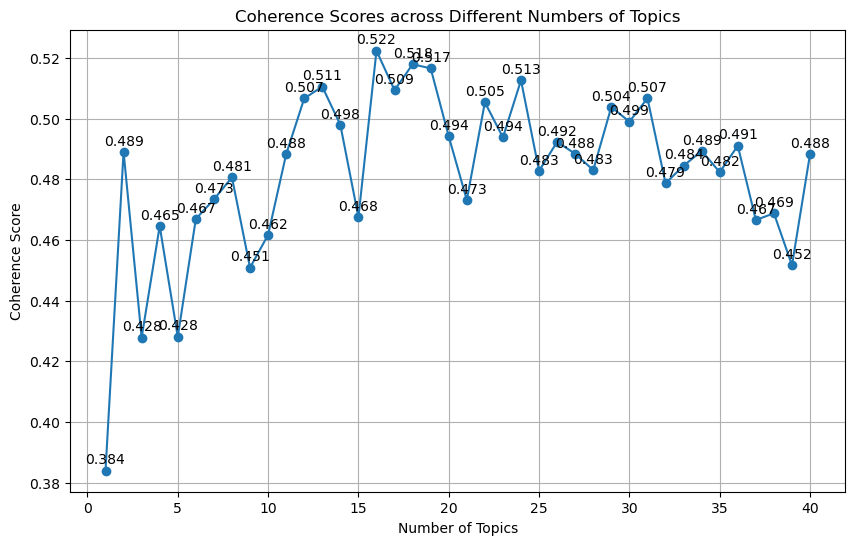

In [154]:
# 主题数量
num_topics = len(LDA_topic_coherence_frame)
# 绘制折线图
plt.figure(figsize=(10, 6))
plt.plot(LDA_topic_coherence_frame['Topic_Num'], LDA_topic_coherence_frame['Coherence_Score'], marker='o')
plt.title('Coherence Scores across Different Numbers of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.grid(True)
# 为每个数据点添加标注
for x, y in zip(LDA_topic_coherence_frame['Topic_Num'], LDA_topic_coherence_frame['Coherence_Score']):
    plt.annotate(f'{y:.3f}',  # 这里是要显示的文本，即y值
                 (x, y),  # 这是要标注的点的坐标
                 textcoords="offset points",  # 指定标注的位置方式
                 xytext=(0,5),  # 指定标注文本的偏移量
                 ha='center')  # 水平居中对齐文本
plt.show()

将主题分配给文档

对每个文档（房源描述）分配一个主题。

In [139]:
# 设置LDA模型
LDA = LdaModel(corpus=tfidf_corpus, id2word=dictionary, num_topics=LDA_topic_coherence_frame.loc[LDA_topic_coherence_frame['Coherence_Score'].idxmax(),'Topic_Num'], random_state=42,iterations=800)
# 对每个文档获取主题分布
doc_topics = [LDA.get_document_topics(bow) for bow in tfidf_corpus]

# 获取每个主题的主要词汇
topics = LDA.print_topics(num_words=40)


查看主题和关键词

查看模型找出的主题和每个主题的关键词。

In [142]:
# 获取每个主题的主题词及其权重
topics = LDA.show_topics(num_topics=16, num_words=20, formatted=False)

# 创建一个list保存每个主题的主题词及权重
LDA_topics_data = []

for topic_num, topic_words in topics:
    for word, weight in topic_words:
        LDA_topics_data.append({'Topic': topic_num, 'Word': word, 'Weight': weight})

# 转换为DataFrame
LDA_topics_frame = pd.DataFrame(LDA_topics_data)

# 保存这个模型生成的主题结果
LDA_topics_frame.to_csv(os.path.join("Data","lda_topics_and_words.csv"), index=False)


In [143]:
# 读取先前保存的LDA 模型生成主题结果
LDA_topics_and_words_frame = pd.read_csv(os.path.join("Data","lda_topics_and_words.csv"))

将doc_topic转换为dataframe，每个文档（listing）的主题分布及其占比

In [67]:
listing_lda_topic = pd.DataFrame(doc_topics)
#循环遍历每一行
for i in range(len(listing_lda_topic)):
    temp_list = listing_lda_topic.iloc[i].dropna()
    # 创建一个全为0的序列，用于替换当前行
    zero_series = pd.Series([0.0] * len(listing_lda_topic.columns), index=listing_lda_topic.columns)
    listing_lda_topic.iloc[i] = zero_series
    for j in temp_list.index:
        # 从原始序列中获取列名和值
        col = temp_list[j][0] if isinstance(temp_list[j], (list, tuple)) else j
        value = temp_list[j][1] if isinstance(temp_list[j], (list, tuple)) else temp_list[j]
        # 更新DataFrame
        listing_lda_topic.at[i, col] = value


保存lda模型后每个房源的主题分布及占比

In [144]:
listing_lda_topic.to_csv(os.path.join("Data","listing_lda_topic.csv"))

读取每个房源的主题占比csv文件

In [145]:
listing_lda_topic = pd.read_csv(os.path.join("Data","listing_lda_topic.csv"))

# 用word2vec模型处理amenities列

**Word 2 Vec**

In [86]:
Airbnb_Listing['amenities'][1]

'["Window guards", "Bathtub", "Hot water kettle", "Laundromat nearby", "Indoor fireplace", "Microwave", "Coffee maker", "Self check-in", "Dining table", "Bed linens", "Books and reading material", "Cleaning available during stay", "Clothing storage: closet and dresser", "Coffee", "Hot water", "Iron", "First aid kit", "Lockbox", "Safe", "Garden view", "Paid parking off premises", "Wine glasses", "Washer", "Portable fans", "Cooking basics", "Heating", "Dishwasher", "Drying rack for clothing", "TV with standard cable", "Freezer", "Oven", "Refrigerator", "Baking sheet", "Body soap", "Hair dryer", "Essentials", "Private entrance", "Long term stays allowed", "Stove", "Carbon monoxide alarm", "Toaster", "Cleaning products", "Extra pillows and blankets", "Wifi \\u2013 37 Mbps", "Dishes and silverware", "Smoke alarm", "Kitchen", "Hangers"]'

In [118]:
# 假设 `texts` 是你的分词后的文本数据（每个文本为词的列表）
texts_word2vec = Airbnb_Listing['amenities']  # 你的分词数据

# 训练Word2Vec模型
model = Word2Vec(sentences=texts_word2vec, vector_size=200, window=10, min_count=1, workers=4)


分词处理：您使用的是 text.split(" ") 来分词。这意味着您假设文本中的每个单词之间由两个空格分隔。请确保这与您的数据格式一致。如果是普通英文文本，通常单词之间只有一个空格，那么应该使用 text.split()。

空文档处理：在 document_vector 函数中，如果文档中所有的词都不在模型的词汇表中，那么 word2vec_model.wv[doc] 将是一个空列表，这会导致 np.mean 报错。您需要处理这种情况。

文档向量计算：当您计算文档向量时，您使用的是 np.array([document_vector(model, doc) for doc in texts])。这里 texts 应该是分词后的文本数据。请确保 texts 和 texts_word2vec 是一致的，即 texts 应该是用于训练 Word2Vec 模型的相同数据。

标签和特征数据：确保 labels 是与 doc_vectors 对应的目标变量数组。labels 应该有与 doc_vectors 相同数量的元素。

模型性能评估：在最后，您计算了准确率，这是评估分类模型性能的一个常用指标。根据您的应用情况，可能还需要考虑其他指标，如精确率、召回率和F1分数。

异常和错误处理：在实际应用中，建议添加异常处理和错误检查，确保代码的健壮性。

In [119]:
Airbnb_Listing_origin = pd.read_csv("./Data/Data_InsideAirbnb/listings.csv.gz")

C:\Users\SBH\AppData\Local\Temp\ipykernel_29876\3764213159.py:1: DtypeWarning: Columns (68) have mixed types. Specify dtype option on import or set low_memory=False.
  Airbnb_Listing_origin = pd.read_csv("./Data/Data_InsideAirbnb/listings.csv.gz")


计算所有listing的average income

In [121]:
# 每个listing的收入与average收入相比
if Airbnb_Listing_origin['price'].dtype == 'object':
    Airbnb_Listing_origin['price'] = Airbnb_Listing_origin['price'].str.replace('$', '').str.replace(',', '').astype(float)
Airbnb_Listing['sum_income'] = Airbnb_Listing_origin['minimum_nights']*2.7*Airbnb_Listing_origin['number_of_reviews_ltm']*Airbnb_Listing_origin['price']

average_income_forlisting = Airbnb_Listing['sum_income'].mean()
average_income_forlisting

7194.986408705343

In [122]:
Airbnb_Listing['profitable'] = (Airbnb_Listing['sum_income'] >= average_income_forlisting).astype(int)

In [155]:
# 转换文本向量
def document_vector(word2vec_model, doc):
    # 移除不在词汇表中的词
    doc = [word for word in doc if word in word2vec_model.wv.key_to_index]
    # 处理空文档的情况
    if len(doc) == 0:
        return np.zeros(word2vec_model.vector_size)
    # 计算均值向量
    return np.mean(word2vec_model.wv[doc], axis=0)

# 为每个文档计算向量
doc_vectors = np.array([document_vector(model, doc) for doc in texts])

In [ ]:
# 随机森林方法

#使用任何类型的分类器来预测是否income超过平均值
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(doc_vectors, Airbnb_Listing['profitable'], test_size=0.2, random_state=42)

# 训练分类器
classifier = RandomForestClassifier(n_estimators=300, random_state=42)
classifier.fit(X_train, y_train)

# 预测测试集
y_pred = classifier.predict(X_test)

# 评估模型
print("Accuracy:", accuracy_score(y_test, y_pred))


In [125]:
#SVM方法
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(doc_vectors, Airbnb_Listing['profitable'], test_size=0.2, random_state=42)

# 创建 SVM 分类器实例
svm_classifier = SVC(random_state=42)

# 训练分类器
svm_classifier.fit(X_train, y_train)

# 预测测试集
y_pred = svm_classifier.predict(X_test)

# 评估模型
print("Accuracy:", accuracy_score(y_test, y_pred))



Accuracy: 0.7956225127913588


**保存该SVM 模型**

In [130]:
dump(svm_classifier, 'svm_classfier_model.joblib')

['svm_classfier_model.joblib']

**读取训练后的SVM模型**

In [134]:
svm_classifier = load('svm_classfier_model.joblib')

In [ ]:
print(model.wv.index_to_key) # <-- the full vocabulary that has been trained

# 可视化

分析得到的主题，并根据需要进行可视化。

**加入地理信息元素绘图**

In [158]:
%%capture --no-stdout
# Transfer pandas dataframe (Airbnb_listing.csv) to geopandas geodataframe
# By using the coordinates ()
from shapely.geometry import Point

# Create geometry column
geometry = [Point(xy) for xy in zip(Airbnb_Listing['longitude'], Airbnb_Listing['latitude'])]

# Converting to GeoDataframe
gdf_listing = gpd.GeoDataFrame(Airbnb_Listing, geometry=geometry)

# Set the CRS
gdf_listing.set_crs("EPSG:4326", inplace=True)  # (EPSG:4326)

print("Converting successful")


# Drop NAs of columns ['description','amenities']
gdf_listing = gdf_listing.dropna(subset=['description','amenities'])
print(f"Now gdf has {gdf_listing.shape[0]:,} rows.")

Converting successful
Now gdf has 86,679 rows.


In [159]:
# 加载数据
gdf_listing = gpd.read_file('London_Boroughs.gpkg')  # 替换为你的数据文件路径
coordinates = gdf_listing[['geometry']].copy()
values = gdf_listing['sum_income'].values

# IDW插值函数
def idw_interpolation(x, y, z, xi, yi, power=2):
    dist = cdist(xi, x)
    dist = np.where(dist == 0, 1, dist)
    weights = 1 / dist**power
    weights /= weights.sum(axis=1)[:, None]
    zi = np.dot(weights, z)
    return zi

# 创建插值网格
x_min, y_min, x_max, y_max = coordinates.total_bounds
xi, yi = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]  # 100x100网格
xi, yi = xi.flatten(), yi.flatten()
xyi = np.vstack((xi, yi)).T

# 进行IDW插值
zi = idw_interpolation(coordinates.values, values, xyi)

# 创建插值后的GeoDataFrame
gdf_interpolated = gpd.GeoDataFrame({'Z': zi}, 
                                    geometry=gpd.points_from_xy(xyi[:, 0], xyi[:, 1]))

# 绘制插值结果
fig, ax = plt.subplots(figsize=(10, 10))
gdf_interpolated.plot(column='Z', ax=ax, alpha=0.5, legend=True,
                      cmap='viridis', markersize=5)

# 添加底图
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.show()

# 保存地图
# fig.savefig('london_housing_price_map.png')

KeyError: 'sum_income'

In [162]:
gdf_listing.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   objectid    33 non-null     int64   
 1   name        33 non-null     object  
 2   gss_code    33 non-null     object  
 3   hectares    33 non-null     float64 
 4   nonld_area  33 non-null     float64 
 5   ons_inner   33 non-null     object  
 6   sub_2011    33 non-null     object  
 7   geometry    33 non-null     geometry
dtypes: float64(2), geometry(1), int64(1), object(4)
memory usage: 2.2+ KB


## 7. Drawing on your previous answers, and supporting your response with evidence (e.g. figures, maps, and statistical analysis/models), how *could* this data set be used to inform the regulation of Short-Term Lets (STL) in London?

::: duedate
( 45 points; Answer due {{< var assess.group-date >}} )
:::

## Sustainable Authorship Tools

Your QMD file should automatically download your BibTeX file. We will then re-run the QMD file to generate the output successfully.

Written in Markdown and generated from [Quarto](https://quarto.org/). Fonts used: [Spectral](https://fonts.google.com/specimen/Spectral) (mainfont), [Roboto](https://fonts.google.com/specimen/Roboto) ([sansfont]{style="font-family:Sans-Serif;"}) and [JetBrains Mono](https://fonts.google.com/specimen/JetBrains%20Mono) (`monofont`).

## References